This script calculates the linear regression and correction factor of all winkler samples. 
CF is calculated by matching neutral density of CTD files with sigma-theta from Winkler samples. 

In [1]:
# Let's find the linear regression for all stations: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import colorcet as ccmport 
import seaborn as sns
import colorcet as cc
# Get CSV files list from a folder
path ='/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/Log'
csv_files = glob.glob(path + "/*.csv")

# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
stations_df = pd.concat(df_list)

#Create a bottle file with all winkler values and other parameters measured when sampling:
#stations_df.to_csv('bottlefile_hly2202.csv')

#Calculating potential density for each bottle sample drawn:
stations_df['sigma-theta']= stations_df['Sigma']*1000 - 1000
stations_df = stations_df.dropna(subset = ['Winkler umol/kg'])


Matching sigma-thetha Winkler density with Thermo_NeutralDensity from CTD files:
1. Need to import "pre" ctd sensor files from station 0 to station 8 with different table format. (First CTD O2 sensor)
2. then, I import the "post" sensor files from station 11 to station 53 (Second CTD O2 sensor)


Importing all CTD files in .cnv format. Concatenating them into one single dataframe "all_df"

In [2]:
#Import required packages:
import matplotlib.pyplot as plt
from pathlib import Path

#Define path name for pre ctd files#
#path1 = Path("/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/CTD_Northbound/")
#csv_files1 = path1.glob("*Pre1dbar.cnv")

#import pre ctd files
#pre_list = [pd.read_csv(file, encoding="ISO-8859-1", delim_whitespace=True, skiprows=319, header=None)
              # .assign(filename=file.stem.split("_")[1]) for file in csv_files1]
#pre_df = pd.concat(pre_list) #concat pre ctd files

#Define path name for post ctd files/Northbound
path2 = Path("/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/CTD_Northbound")
csv_files2 = path2.glob("*Pcaldown1dbar.cnv")

#import post Northbound ctd files
postnorth_list = [pd.read_csv(file2, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(filename=file2.stem.split("_")[1]) for file2 in csv_files2]

postnorth_df = pd.concat(postnorth_list) #concat post northbound ctd files

#Define path name for post ctd files/Southbound
path3 = Path("/Users/mariacristinaalvarez/Documents/Github/ArcticO2/HLY2022_data/CTD_Southbound")
csv_files3 = path3.glob("*Pcaldown1dbar.cnv")

#import post Southbound ctd files
postsouth_list = [pd.read_csv(file3, encoding="ISO-8859-1", delim_whitespace=True, skiprows=311, header=None)
               .assign(filename=file3.stem.split("_")[1]) for file3 in csv_files3]

postsouth_df = pd.concat(postsouth_list) #concat post southbound ctd files

# Concatenate all DataFrames
all_df = pd.concat([postnorth_df, postsouth_df])

We will use TEOS-10 for our analysis.
gsw package is used to calculate Absolute Salinity g/kg and Conservative Temperature.

Since neutral density can't be calculated at high latitudes (<64N), we are exploring Thermodynamic neutral density by Remi Tailleux, U. of Reading,

In [3]:
import gsw
from gsw_gammat_analytic_CT_exact import gsw_gammat_analytic_CT_exact

#Calculate Reference Composition Salinity and Conservative Temperature

all_df['SA'] = gsw.SA_from_SP(all_df[4], all_df[0],all_df[20],all_df[19]) 


#Calculating Conservative Temperature from potential temperature
all_df['theta'] = gsw.pt0_from_t(all_df['SA'],all_df[2],all_df[0])
all_df['CT'] = gsw.conversions.CT_from_pt(all_df['SA'],all_df['theta']) #conservative temperature ITS-90

#Calculate potential density
#all_df['sigma_t'] = gsw.density.sigma0(all_df['SA'], all_df['CT'])

#Calculate gamma_T Tailleux routine:
all_df['gammat_teos10'],all_df['zref_teos10'],all_df['pref_teos10'],all_df['sigref_teos10'] = gsw_gammat_analytic_CT_exact(all_df['SA'],all_df['CT'])

Matching Winkler sigma-theta values with ctd GammaT values (from CTD) to get a CF.


In [10]:
#Creating a new dataframe with matched values 
all_df.rename(columns={'filename':'Cast'}, inplace=True)
all_df['Cast'] = all_df['Cast'].astype(np.int64)

stations_df = stations_df.dropna(subset = ['Winkler umol/kg'])
stations_df['Cast'] = stations_df['Cast'].astype(np.int64)

#stations_df.dropna(subset=['sigma-theta'], inplace=True).astype(np.int64)
all_df = all_df.round({'gammat_teos10':4})
stations_df = stations_df.round({'sigma-theta': 4})

all_df.set_index('Cast').sort_index(ascending=True)
stations_df.set_index('Cast').sort_index(ascending=True)
#group1 = stations_df.sort_values(['sigma-theta'], ascending=True).groupby('Station #')
#df2=df.sort_values(['Courses','Fee'],ascending=False).groupby('Courses').head(3)
d1 = stations_df.sort_values('sigma-theta', ascending=True)
d2 = all_df.sort_values('gammat_teos10', ascending=True)

merged_sigma = pd.merge_asof(d1,d2,left_on='sigma-theta', right_on='gammat_teos10', direction='nearest', by='Cast', allow_exact_matches=True)
merged_sigma['CF'] = merged_sigma['Winkler umol/kg']/merged_sigma[16]
#merged_sigma['CF'] = merged_sigma['CF'].dropna()
merged_sigma['CF'].mean()

0.9976756292555425

In [6]:
merged_sigma[0].max()

257.0

In [4]:
#Creating a new dataframe with matched values 
all_df.rename(columns={'filename':'Station #'}, inplace=True)

all_df['Station #'] = all_df['Station #'].astype(np.int64)
stations_df['Station #'] = stations_df['Station #'].astype(np.int64)

#stations_df.dropna(subset=['sigma-theta'], inplace=True).astype(np.int64)
#all_df = all_df.round({'gammat_teos10':4})
#stations_df = stations_df.round({'sigma-theta': 4})

#all_df.set_index('Station #').sort_index(ascending=True)
#stations_df.set_index('Station #').sort_index(ascending=True)

d1 = stations_df.sort_values('sigma-theta', ascending=True)
d2 = all_df.sort_values('gammat_teos10', ascending=True)

merged_sigma = pd.merge_asof(d2,d1,right_on='sigma-theta', left_on='gammat_teos10',allow_exact_matches=True, direction='nearest', by='Station #')

merged_sigma['CF'] = merged_sigma['Winkler umol/kg']/merged_sigma[16]
merged_sigma['CF'].mean()

1.0245408801304

In [69]:
#Creating a new dataframe with matched values 
#all_df.rename(columns={'filename':'Station #'}, inplace=True)

#all_df['Station #'] = all_df['Station #'].astype(np.int64)
#stations_df['Station #'] = stations_df['Station #'].astype(np.int64)


all_df.rename(columns={'filename':'Cast'}, inplace=True)

all_df['Cast'] = all_df['Cast'].astype(np.int64)
stations_df['Cast'] = stations_df['Cast'].astype(np.int64)

#stations_df.dropna(subset=['sigma-theta'], inplace=True).astype(np.int64)
#all_df = all_df.round({'gammat_teos10':4})
#stations_df = stations_df.round({'sigma-theta': 4})

#all_df.set_index('Station #').sort_index(ascending=True)
#stations_df.set_index('Station #').sort_index(ascending=True)

d1 = stations_df.sort_values('sigma-theta', ascending=True)
d2 = all_df.sort_values('gammat_teos10', ascending=True)

merged_sigma1 = pd.merge_asof(d2,d1,right_on='sigma-theta', left_on='gammat_teos10',allow_exact_matches=True, direction='nearest', by='Cast')

merged_sigma1['CF'] = merged_sigma1['Winkler umol/kg']/merged_sigma1[16]
merged_sigma1['CF'].mean()

1.0157902969303667

In [70]:
merged_sigma1[0].max()

4296.0

In [21]:
stations_df['sigma-theta'].hasnans

False

In [18]:
#Creating a new dataframe with matched values 
all_df.rename(columns={'filename':'Station #'}, inplace=True)

all_df['Station #'] = all_df['Station #'].astype(np.int64)
stations_df['Station #'] = stations_df['Station #'].astype(np.int64)

all_df.rename(columns={19:'Latitude'}, inplace=True)
all_df['Latitude'] = all_df['Latitude'].astype(np.int64)

#stations_df.dropna(subset=['sigma-theta'], inplace=True).astype(np.int64)
#all_df = all_df.round({'gammat_teos10':4})
#stations_df = stations_df.round({'sigma-theta': 4})

all_df.set_index('Station #').sort_index(ascending=True)
stations_df.set_index('Station #').sort_index(ascending=True)

d1 = stations_df.sort_values('sigma-theta', ascending=True).astype(np.int64)
d2 = all_df.sort_values('gammat_teos10', ascending=True).astype(np.int64)

merged_sigma = pd.merge_asof(d1,d2,left_on='sigma-theta', right_on='gammat_teos10', direction='nearest', allow_exact_matches=True, by='Latitude')

merged_sigma['CF'] = merged_sigma['Winkler umol/kg']/merged_sigma[16]
merged_sigma['CF'].mean()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

Using the mean value of the correction factor we can correctd ctd oxygen values.
CF mean = 1.035307

In [57]:
#If I drop first 100 meters things looks better
#d = merged_sigma.loc[(merged_sigma[0 ] >= 0) & (merged_sigma[0 ] <= 100)]
#d['CF'].mean()
d = merged_sigma.loc[(merged_sigma['CF'] >= 0.9) & (merged_sigma['CF'] <= 1.2)]
d['CF'].mean()
#t = merged_sigma.loc[(merged_sigma[0] >= 90) & (merged_sigma[0] <= 5000)]
#t['CF'].mean()

1.0256422474730087

In [11]:
#Correcting CTD O2 values: 
#all_df['O2_correct']= all_df[16]*1.035307
all_df['O2_correct']= all_df[16]*1.02960



Now let's do Linear Regression

/var/folders/2b/pwxn7kh9125g4k207h_wmc8h0000gn/T/ipykernel_48626/1571692364.py:4: UserWarning: 
The palette list has fewer values (31) than needed (42) and will cycle, which may produce an uninterpretable plot.
  sns.relplot(x=0,


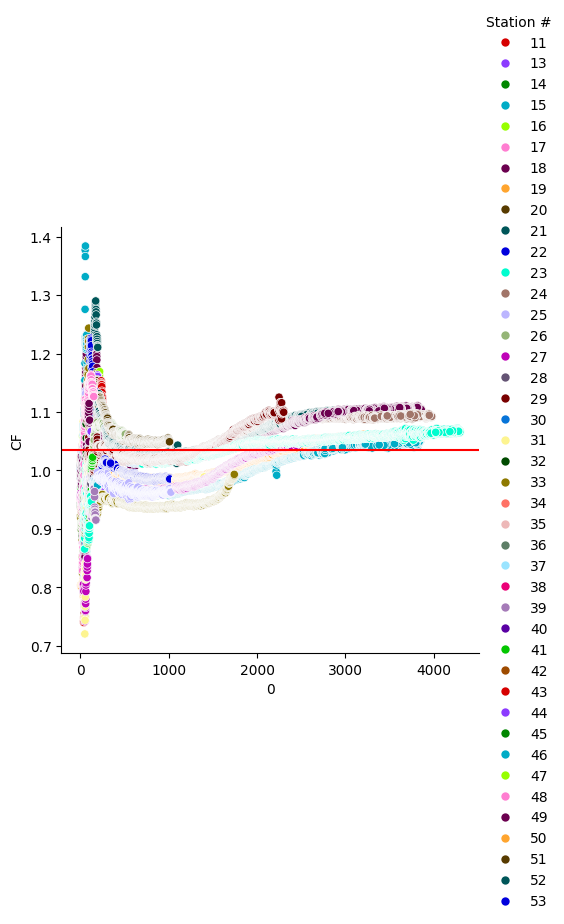

In [6]:

#custom_palette = sns.color_palette("viridis", 29)
palette = sns.color_palette(cc.glasbey, n_colors=31)

sns.relplot(x=0,
            y='CF',
            data=merged_sigma,
            kind='scatter',
            hue='Station #', legend='full', palette=palette)

plt.axhline(y=1.035307, color='r', linestyle='-')

plt.show()

Exploring Time-drift in CF

In [85]:
#Creating different blocks
block1 = merged_sigma.loc[(merged_sigma['Cast'] >=10) & (merged_sigma['Cast'] <=28)]
block2 = merged_sigma.loc[(merged_sigma['Cast'] >=29) & (merged_sigma['Cast'] <=54)]
postctd = merged_sigma.loc[(merged_sigma['Cast'] >=10) & (merged_sigma['Cast'] <=54)]

#Calculating CF for each block
mean1 = block1['CF'].mean()
mean2 = block2['CF'].mean()
mean3 = merged_sigma['CF'].mean()
mean1, mean2, mean3

(1.0194976304251495, 0.9740839408667382, 0.9989843972825773)

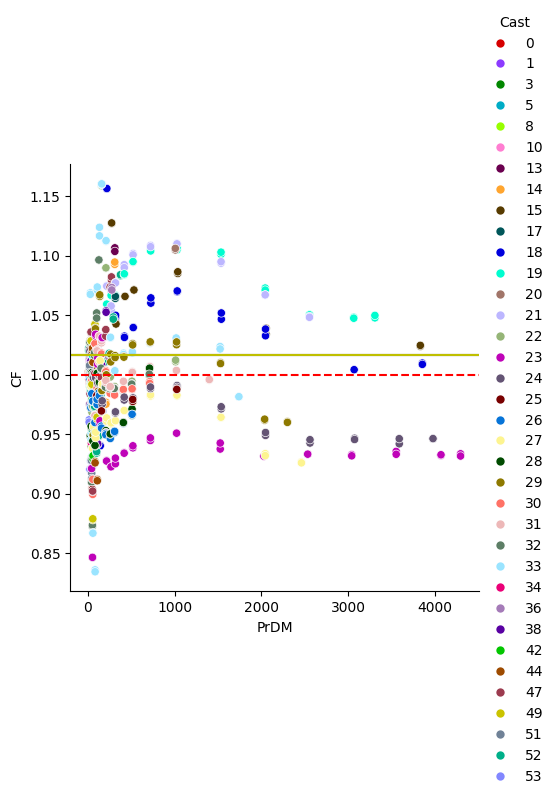

In [8]:
#Creating different blocks
block1 = merged_sigma.loc[(merged_sigma['Station #'] >=10) & (merged_sigma['Station #'] <=25)]
block2 = merged_sigma.loc[(merged_sigma['Station #'] >=26) & (merged_sigma['Station #'] <=53)]


#Calculating CF for each block
mean1 = block1['CF'].mean
mean2 = block2['CF'].mean


#station15  = all_df.loc[all_df['Station #'] == 15]
#custom_palette = sns.color_palette("viridis", 29)
palette = sns.color_palette(cc.glasbey, n_colors=36)

sns.relplot(x='PrDM',
            y='CF',
            data=merged_sigma,
            kind='scatter',
            hue='Cast', legend='full', palette=palette)
plt.axhline(y=1.016667, color='black', linestyle='-')
plt.axhline(y=1.016667, color='y', linestyle='-')
plt.axhline(y=0.999833, color='r', linestyle='dashed')
#plt.axhline(y=1.022251, color='g', linestyle='dotted')


plt.show()

Text(0.5, 0, 'CTD O2 umol/kg')

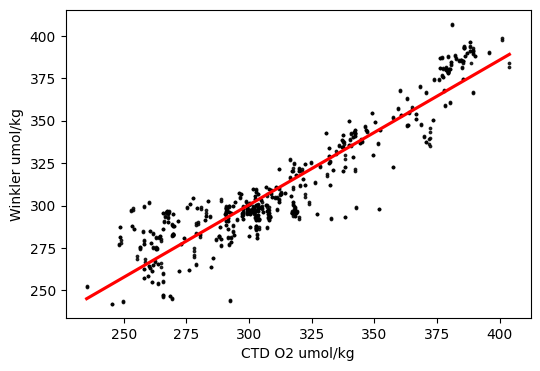

In [22]:
import scipy as sp
linreg = sp.stats.linregress(merged_sigma[16], merged_sigma['Winkler umol/kg'])

#plt.scatter(merged_sigma[16], merged_sigma['Winkler umol/kg'], color = )
#plt.plot(np.arange(-1,4,0.1), linreg.slope*np.arange(-1,4,0.1)+linreg.intercept, 'r')
#plt.text(3, 2, "R$^2$=" + str( (np.round(linreg.rvalue**2*100)/100)) )
#plt.text(3, 1.75, "p-value=" + str(linreg.pvalue) )

palette = sns.color_palette(cc.glasbey, n_colors=30)
fig,ax = plt.subplots(figsize=(6,4))
ax = sns.regplot(x=merged_sigma[16],
            y=merged_sigma['Winkler umol/kg'],scatter_kws={'s':3}
            ,color= "0", ci=None, line_kws=dict(color="r"))
ax.set_xlabel("CTD O2 umol/kg")
#ax.text(250, 400,'CF Mean = 1.035307 ', fontsize = 10)

Investigating if correction works at station 15

In [12]:
#Convert Station # column to int64
all_df['Station #'] = pd.to_numeric(all_df['Station #'])
#Selecting only CTD Station # 15, matches with Canadian cruise
station15  = all_df.loc[all_df['Station #'] == 15]

compare = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/d2022-045-0022.cnv', encoding="ISO-8859-1", delim_whitespace=True, skiprows=569, header=None)
#Calculate SA, CT #Can't calculate, file does not contain density, latitude and longitude t caculate TEOS-10
#compare['SA'] = gsw.SA_from_SP(compare[4], compare[1],compare[20],compare[19]) 
#compare['CT'] = gsw.conversions.CT_from_pt(compare['SA'],compare[20]) #conservative temperature ITS-90
#Calculate in-situ density and sigma theta

#Will use EOS-80 for this purposes
compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
compare['sigma-den'] = compare['density-rho'] - 1000

oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)

#Selecting Winkler values from station 15
#stations_df['Station #'] = pd.to_numeric(stations_df['Station #'])
Winkler_S15 = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/Log/HEALY2202_S13C15.csv')

Text(0.5, 1.0, 'Station 15')

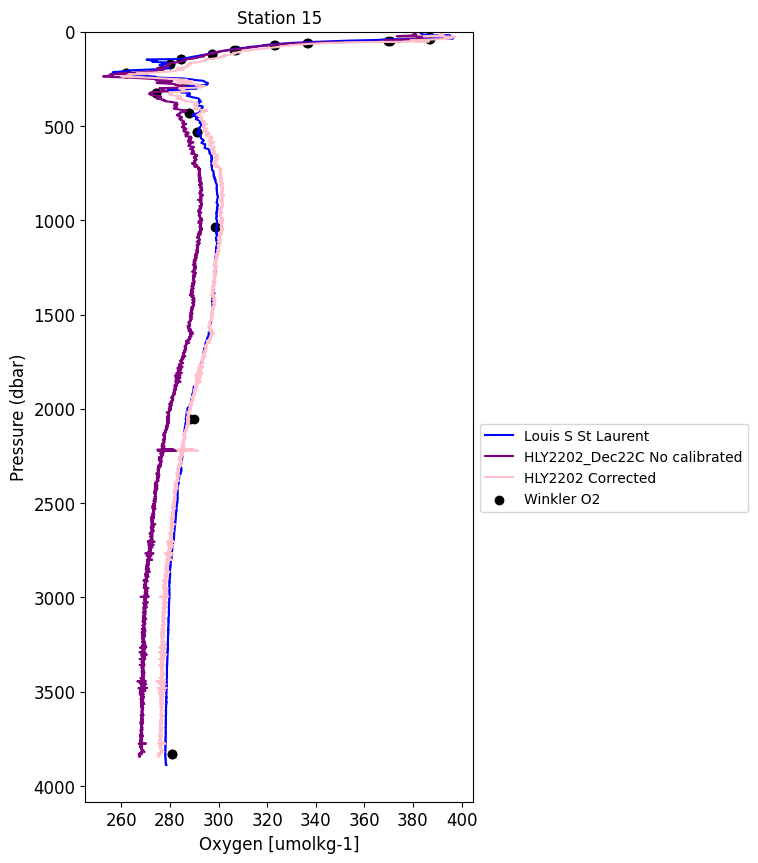

In [13]:
# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(oxy,compare[1],color='blue', markersize=0.5, label= 'Louis S St Laurent')
plt.plot(station15[16],station15[0],color='purple', markersize=0.1, label= 'HLY2202_Dec22C No calibrated')
plt.plot(station15['O2_correct'],station15[0],color='pink', markersize=0.1, label= 'HLY2202 Corrected')
#plt.plot(station15['CFO2_above500'],station15[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station15['CFO2_below500'],station15[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
plt.scatter(Winkler_S15['Winkler umol/kg'],Winkler_S15['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Station 15')

Let's see how the North Pole station looks like compared to Geotraces file

Text(0.5, 1.0, 'North Pole')

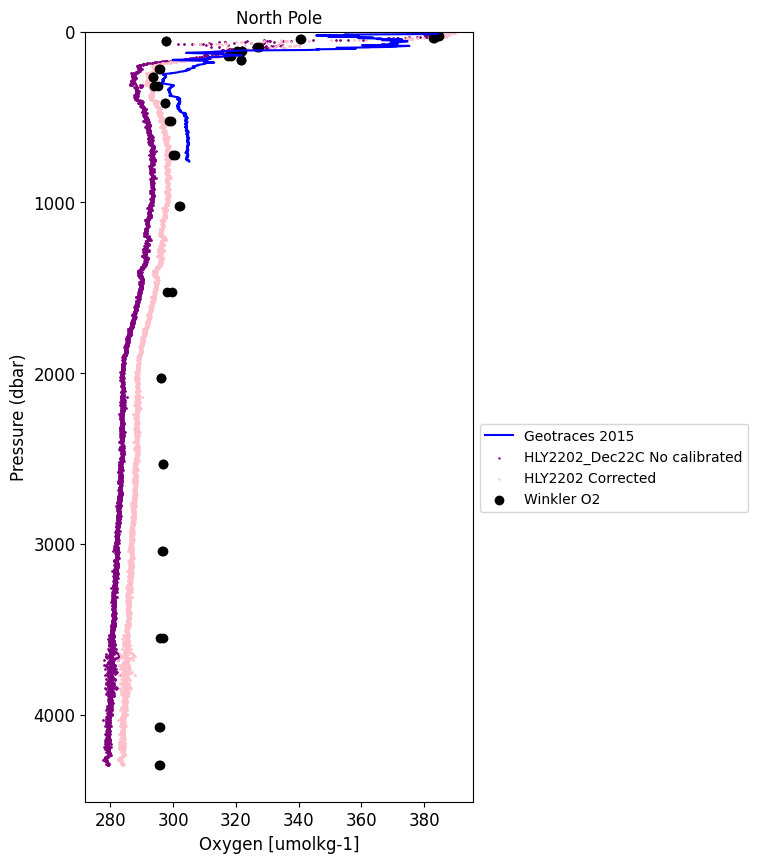

In [30]:
#Selecting only CTD North Pole Cast
station23  = all_df.loc[all_df['Cast'] == 23]
import xarray as xr
geo_lat90 = xr.open_dataset('/Users/mariacristinaalvarez/Documents/NorthPoleO2/Geotraces2015/East/33HQ20150809_00032_00004_ctd.nc')
#Calculate SA, CT #Can't calculate, file does not contain density, latitude and longitude t caculate TEOS-10
#compare['SA'] = gsw.SA_from_SP(compare[4], compare[1],compare[20],compare[19]) 
#compare['CT'] = gsw.conversions.CT_from_pt(compare['SA'],compare[20]) #conservative temperature ITS-90
#Calculate in-situ density and sigma theta

#Will use EOS-80 for this purposes
#compare['density-rho'] = gsw.density.rho(compare[18], compare[3],compare[1])
#compare['sigma-den'] = compare['density-rho'] - 1000

#oxy =(compare[17]*44.6*1000)/(compare['sigma-den']+1000)

#Selecting Winkler values from station 15
#merged_sigma['Cast'] = pd.to_numeric(merged_sigma['Cast'])
Winkler_S23 = pd.read_csv('/Users/mariacristinaalvarez/Documents/NorthPoleO2/HLY2022_data/Log/HEALY2202_S21C23.csv')

# Plot the data SALINITY
plt.figure(figsize=(5,10))
plt.plot(geo_lat90.oxygen,geo_lat90.pressure,color='blue', markersize=0.5, label= 'Geotraces 2015')
plt.scatter(station23[16],station23[0],color='purple', s= 0.5,label= 'HLY2202_Dec22C No calibrated')
plt.scatter(station23['O2_correct'],station23[0],color='pink', s= 0.5,label= 'HLY2202 Corrected')
#plt.plot(station23['CFO2_above500'],station23[0],color='green', markersize=0.1, label= 'HLY2202_Dec22C/Pcal CF from upper 500m ')
#plt.plot(station23['CFO2_below500'],station23[0],color='orange', markersize=0.1, label= 'HLY2202_Dec22C CF/Pcal from below 500m')

#plt.scatter(merged_sigma['Sbox0Mm/Kg'],merged_sigma['PrDM'],color='red', marker='o', label= 'Bottle O2')
plt.scatter(Winkler_S23['Winkler umol/kg'],Winkler_S23['PrDM'],color='black', marker='o', label= 'Winkler O2')

plt.legend( loc='upper left', bbox_to_anchor=(1, 0.5))
plt.gca().invert_yaxis()
plt.xlabel('Oxygen [umolkg-1]',fontsize=12)
plt.ylabel('Pressure (dbar)' ,fontsize=12)
plt.ylim(top=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('North Pole')